In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import os
from tqdm import tqdm

sc.set_figure_params(figsize=(6, 4))

# Whole dataset

In [ ]:
def get_id_ctype(path, adata):
    adata.obs['neil_cell_type'] = ''
    with open(path, 'r') as f:
        f.readline()
        for line in f.readlines():
            cell, ctype = line.rstrip().split(',')
            cell = cell.split('_')[1] + '-1'
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'neil_cell_type'] = ctype
                
                
def get_adata(path, cpath):
    adata = sc.read_10x_mtx(path, cache=True)
    get_id_ctype(cpath, adata)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata

root_path = 'data/'
lst_dirs = [dname for dname in os.listdir(root_path) if os.path.isdir(root_path+dname) and dname.startswith('2')]

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = root_path + d + '/premrna_outs/filtered_feature_bc_matrix'
    sample = d.split('_')[-1]
    path_ctype = root_path + d + '/premrna_outs/%s_broad_celltype.csv' % sample
    if i == 0:
        adata = get_adata(path, path_ctype)
    else:
        tmp = get_adata(path, path_ctype)
        adatas.append(tmp)

del tmp
adata = adata.concatenate(adatas)
adata = adata[adata.obs.neil_cell_type != '']
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

cc_genes = pd.read_table('data/Macosko_cell_cycle_genes.txt', delimiter='\t')
s_genes = list(cc_genes['S'].dropna())
g2m_genes = list(cc_genes['G2.M'].dropna())

s_genes = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

sc.tl.score_genes_cell_cycle(adata, s_genes, g2m_genes)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax = ax.flatten()
sf = adata.obs.groupby('batch').size()
sns.barplot(x="batch", y="count", data=pd.DataFrame({'batch':sf.index, 'count':sf.values}), ax=ax[0])
ax[0].set_xticklabels([d.split('_')[-1] for d in lst_dirs], rotation=90)
ax[0].set_xlabel('')

sf = adata.obs.groupby('neil_cell_type').size()
sns.barplot(x="Cell Type", y="count", data=pd.DataFrame({'Cell Type':sf.index, 'count':sf.values}), ax=ax[1])
ax[1].set_xlabel('')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)


sf = adata.obs.groupby('phase').size()
sns.barplot(x="phase", y="count", data=pd.DataFrame({'phase':sf.index, 'count':sf.values}), ax=ax[2])
ax[2].set_xlabel('')

plt.tight_layout(pad=0.0)
plt.show()

In [ ]:
adata.write('data/merged.h5ad')

# Only hepatocytes

# Visum

In [12]:
def get_id_ctype(path, adata):
    adata.obs['neil_cell_type'] = ''
    with open(path, 'r') as f:
        f.readline()
        for line in f.readlines():
            cell, ctype = line.rstrip().split(',')
            cell = cell.split('_')[1]
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'neil_cell_type'] = ctype
        
        
def get_cyc(path, adata):
    adata.obs['cycling'] = 'no'
    with open(path, 'r') as f:
        for line in f.readlines():
            cell, cyc = line.rstrip().split(',')
            cell = cell + '-1'
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'cycling'] = cyc
            
                
                
def get_adata(path, cpath, cyc_path):
    adata = sc.read_visium(path)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=10)
    get_id_ctype(cpath, adata)
    get_cyc(cyc_path, adata)
    adata = adata[adata.obs.neil_cell_type == 'Hepatocytes']
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata


visum_path = root_path + 'visum/'
lst_dirs = [dname + '/outs/' for dname in os.listdir(visum_path) if os.path.isdir(visum_path+dname) and dname.startswith('2')]

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = visum_path + d
    sample = d.split('_')[2]
    subsample = d.split('_')[3][:2]
    path_ctype = visum_path + d + '../{0}{1}_broad_celltype.csv'.format(sample, subsample)
    path_cyc = root_path + 'visum_cycling.csv'
    if i == 0:
        adata = get_adata(path, path_ctype, path_cyc)
    else:
        tmp = get_adata(path, path_ctype, path_cyc)
        adatas.append(tmp)

  0%|          | 0/2 [00:00<?, ?it/s]Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'neil_cell_type' as categorical
... storing 'cycling' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


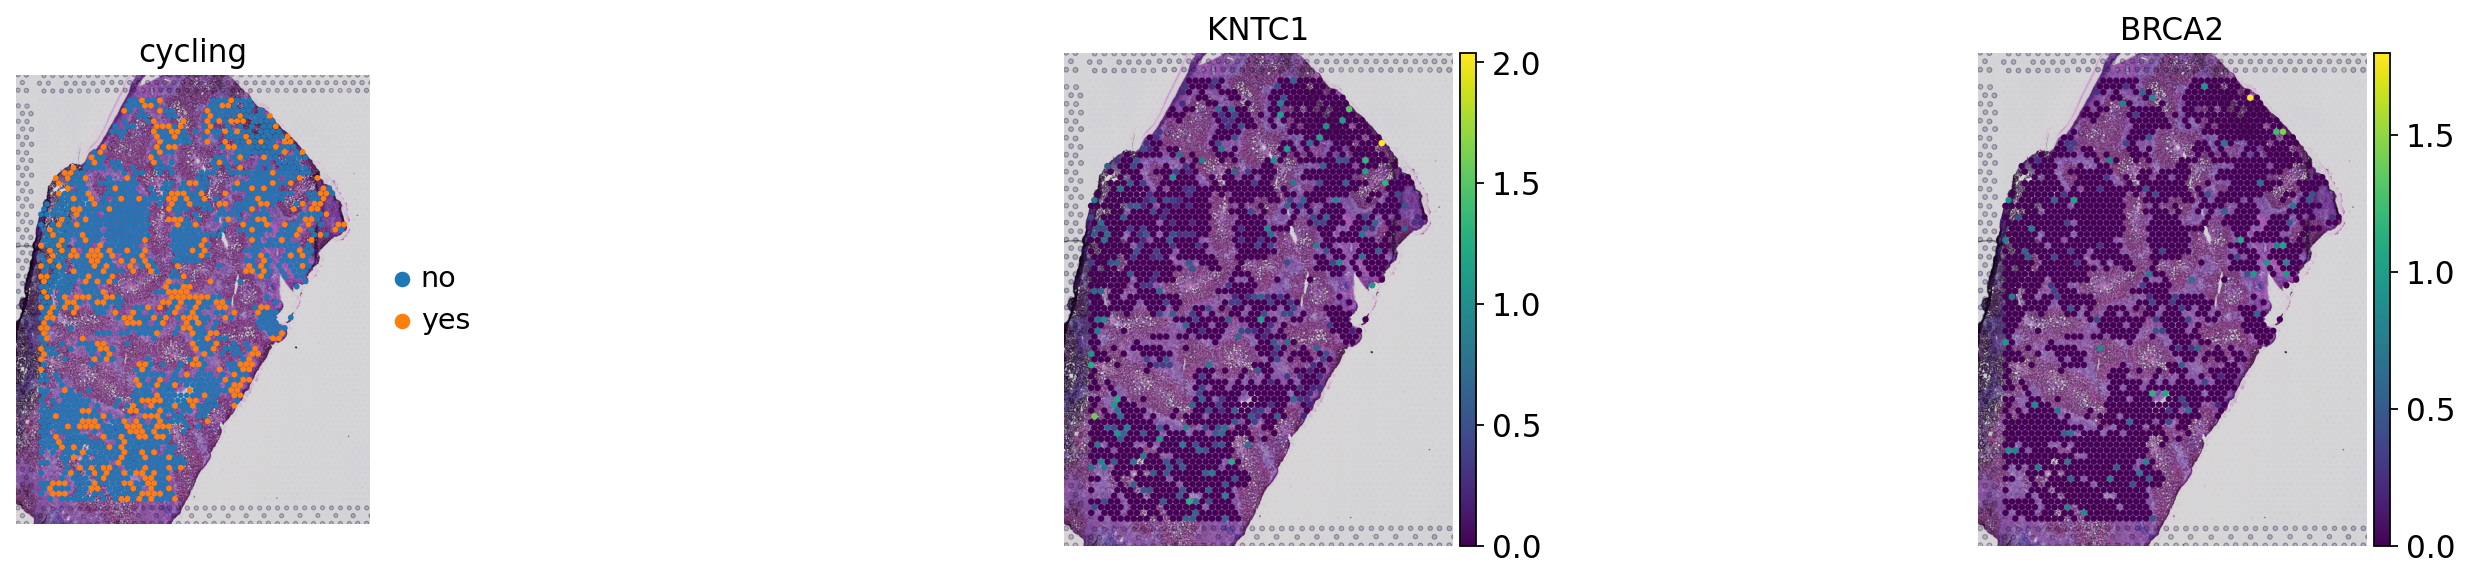

... storing 'neil_cell_type' as categorical
... storing 'cycling' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


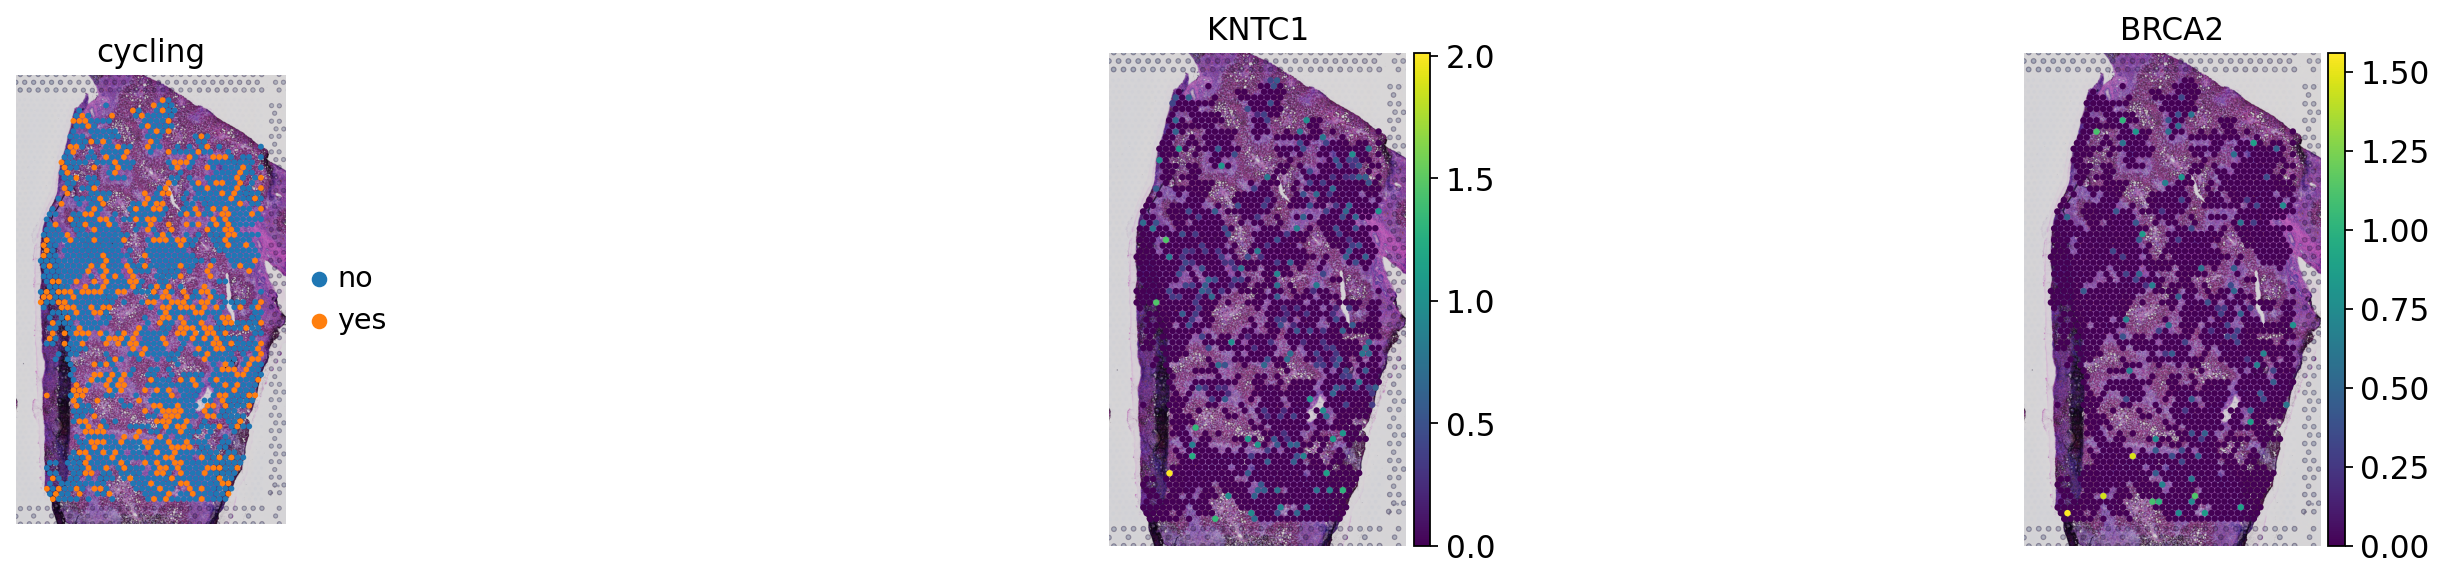

In [13]:
sc.pl.spatial(adata, color=["cycling", 'KNTC1', 'BRCA2'], size=1.5, frameon=False)
sc.pl.spatial(tmp, color=["cycling", 'KNTC1', 'BRCA2'], size=1.5, frameon=False)

In [ ]:
scvi.data.setup_anndata(h_adata, layer="counts", batch_key="donor")

In [ ]:
vae = scvi.model.SCVI(h_adata)

In [ ]:
vae.train()

In [ ]:
h_adata.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
sc.pp.neighbors(h_adata, use_rep="X_scVI")
sc.tl.umap(h_adata)

In [ ]:
sc.pl.umap(
    h_adata,
    color=["donor", "cycling"],
    frameon=False,
)

In [ ]:
de_df = vae.differential_expression(
    groupby="cycling",
    group1='yes'
)

In [ ]:
de = de_df[(de_df.lfc_mean > 0) & (de_df.bayes_factor > 3) & de_df.non_zeros_proportion1 > 0.1]
de

In [ ]:
sc.pl.umap(
    h_adata,
    color=["cycling"] + list(de.index),
    frameon=False, ncols= 3
)

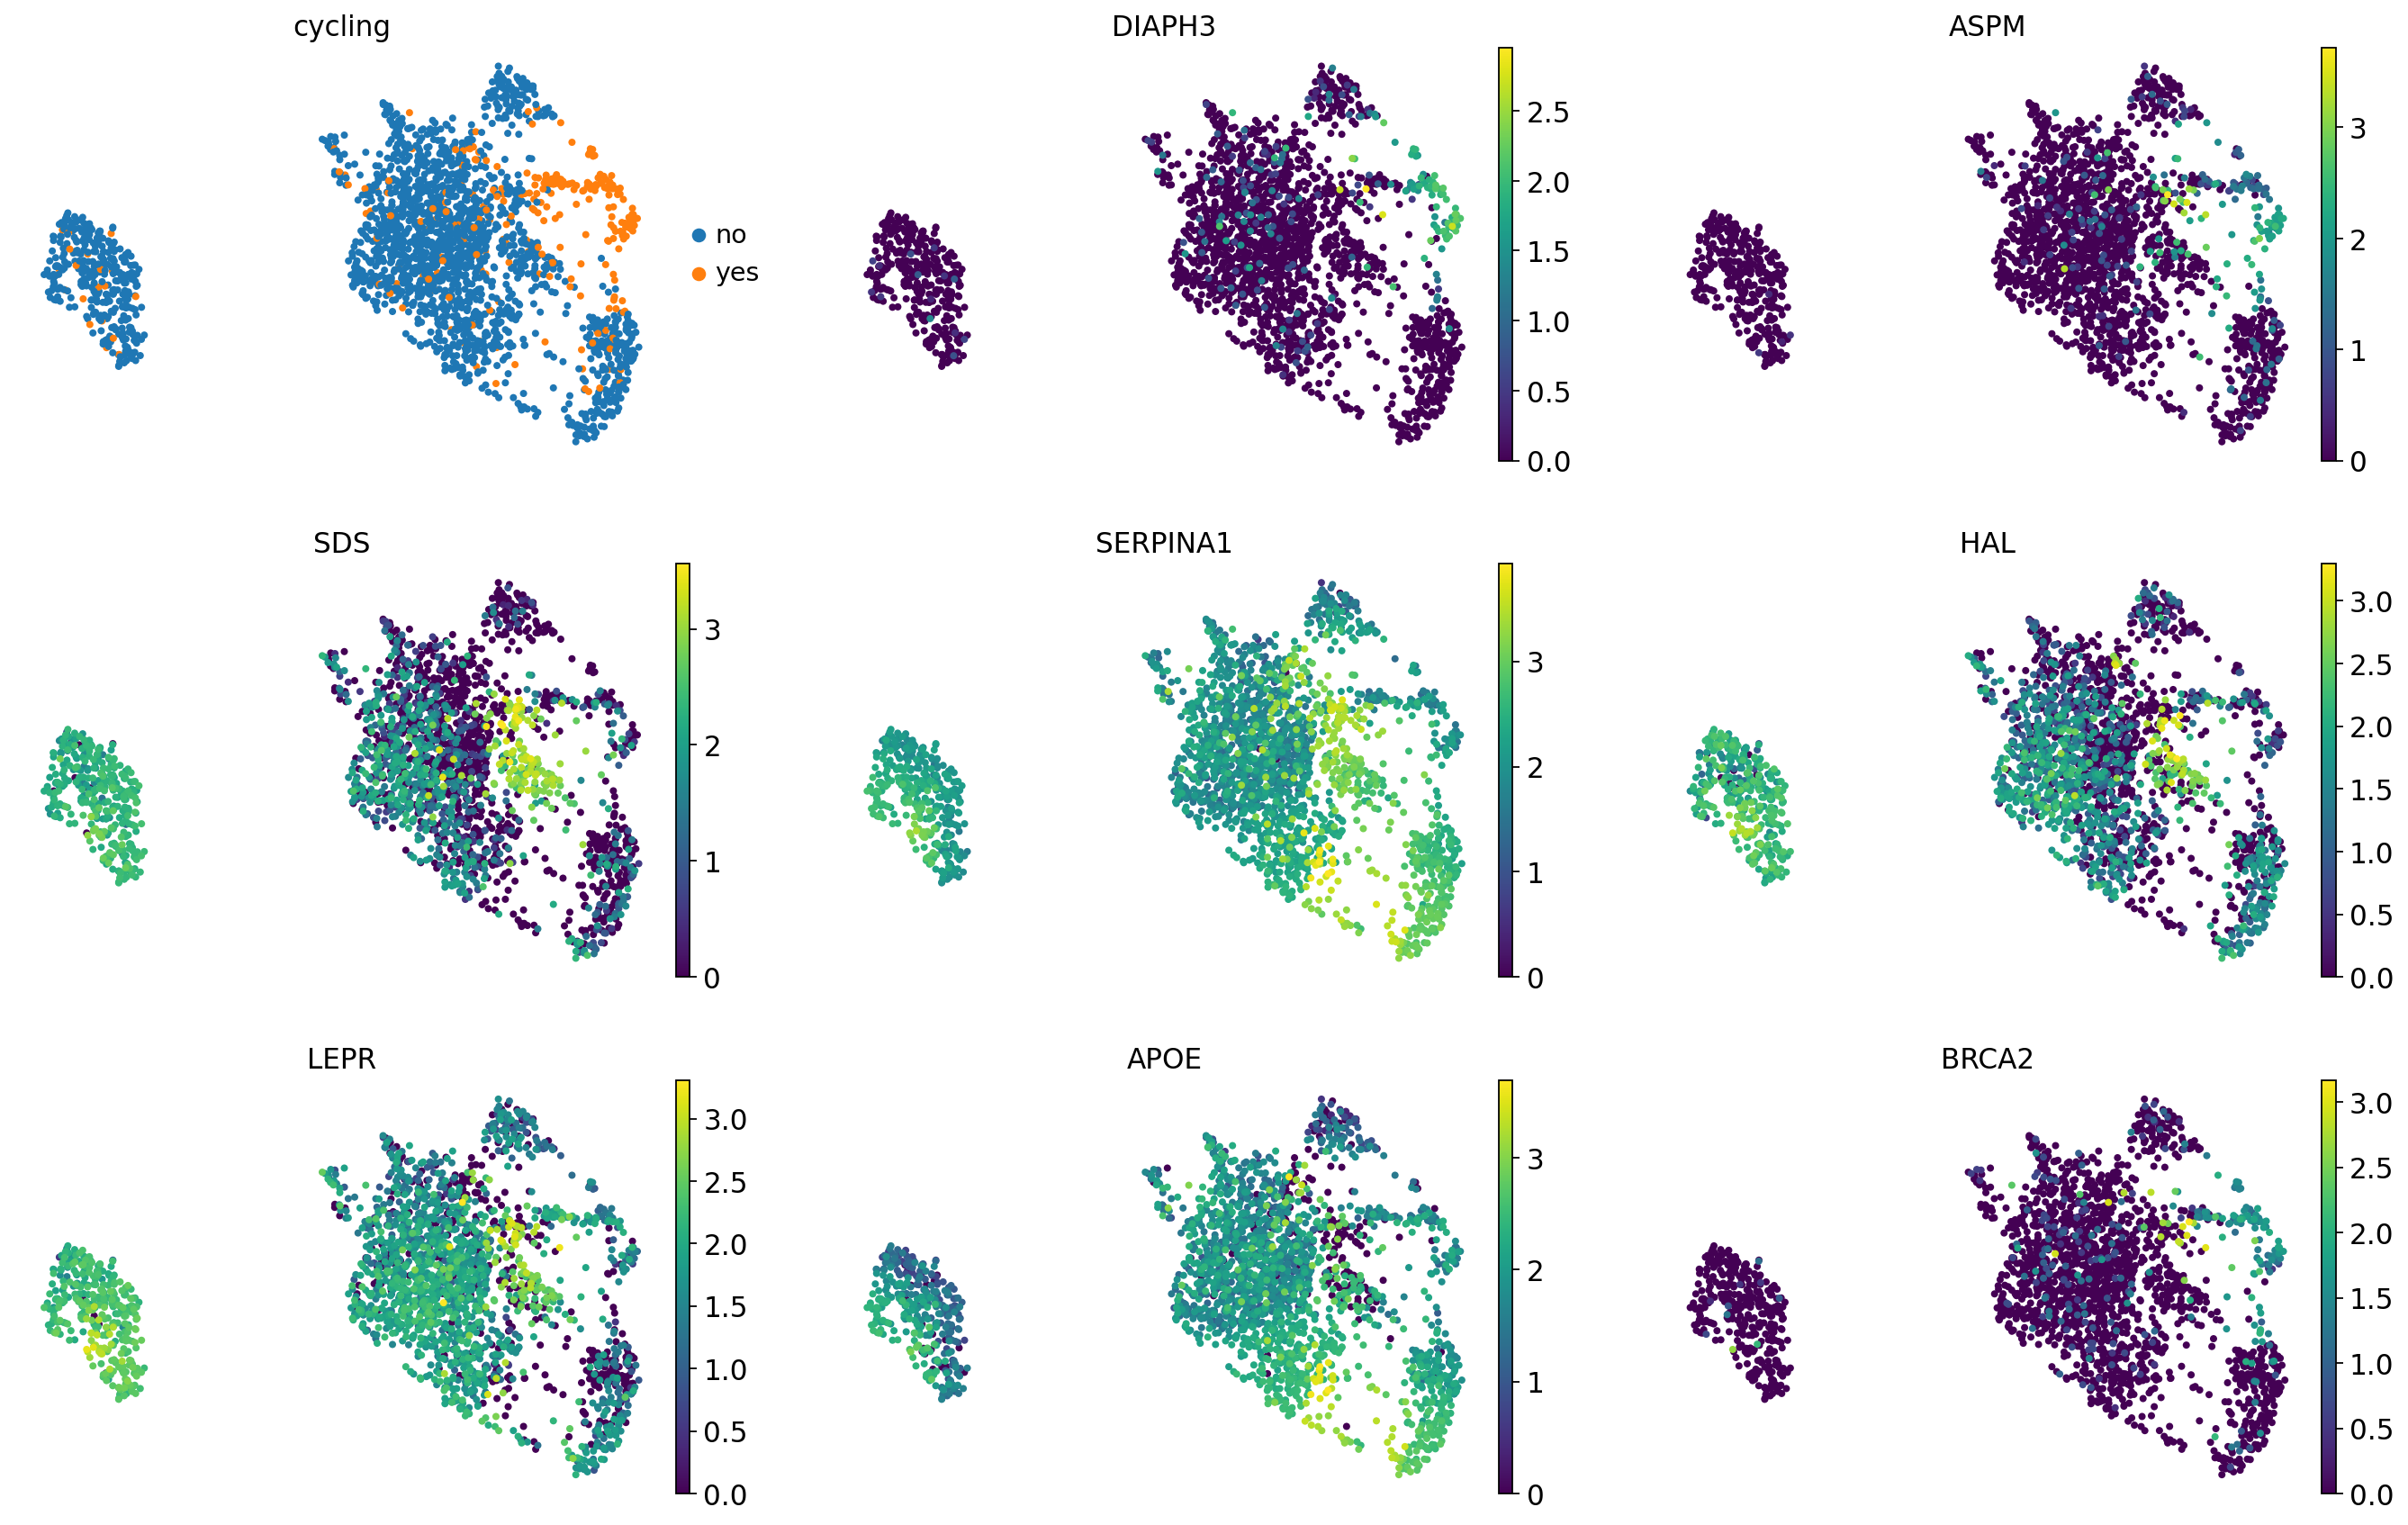

In [15]:

sc.pl.umap(
    h_adata,
    color=["cycling"] + ['DIAPH3', 'ASPM', 'SDS', 'SERPINA1', 'HAL', 'LEPR', 'APOE'],
    frameon=False, ncols= 3
)